# Introduction

We will examin the Large Moview Review dataset also known as the imdb reviews. Information from TensorFlow can be found [here](https://www.tensorflow.org/datasets/catalog/imdb_reviews) as well as links to the original source. This dataset comprises a large number of highly polar (extremely positive or negative) movie reviews pulled from [IMDb](https://www.imdb.com/) -- a website for rating movies. The target application is text based binary sentiment classification.

The following resources have been used to help in this investigation:
- [TF - Basic Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Loading Dataset

In [2]:
#Download data into imdb directory
#NOTE: Will also download unsupervised data
#NOTE: Subsequent calls will reuse
train_ds, ds_info = tfds.load('imdb_reviews', data_dir='imdb', 
                              split='train', with_info=True)

Looks like that went pretty well, so let's real quick check a single example to make sure it's what we expect. Also, we note that to keeps things simple we are just looking at the training split of the dataset. There are also test and unsupervised splits. We will make some comments about these other splits when appropriate.

In [3]:
for example in train_ds.take(1):
    print('Text: {}\n'.format(example['text']))
    print('Label: {}'.format(example['label']))

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Label: 0


We have just extracted the training split from the dataset and examined a single example. We can see that in each example we have the review text and a label (in this case 0). The only major thing worth noting is that our text is formatted as a byte string.

# Exploration

First, we will convert our dataset object to a dataframe for easier exploration and understanding. We note that the label 0 corresponds to negative and 1 to positive.

In [4]:
class_map = {0:'Negative', 1:'Positive'}

In [5]:
train_df = tfds.as_dataframe(train_ds)
train_df.columns = ['Label', 'Text']
train_df['Text'] = train_df['Text'].str.decode('utf-8')
train_df['Label'] = train_df['Label'].map(class_map)

In [6]:
train_df.head()

,Label,Text
0,Negative,This was an absolutely terrible movie. Don't b...
1,Negative,"I have been known to fall asleep during films,..."
2,Negative,Mann photographs the Alberta Rocky Mountains i...
3,Positive,This is the kind of film for a snowy Sunday af...
4,Positive,"As others have mentioned, all the women that g..."


Great! We have converted our byte strings to regular strings, mapped the integer label to a string, and thrown everything in a dataframe. We can see the first few rows of this in the output above.

We can now easily qualify and quantify our data, so let's do that.

In [7]:
print('Training Samples: {}'.format(train_df.shape[0]))

Training Samples: 25000


That is consistent with the documentation, and we note that the there are also 25,000 testing samples in addition to 50,000 unlabeled examples.

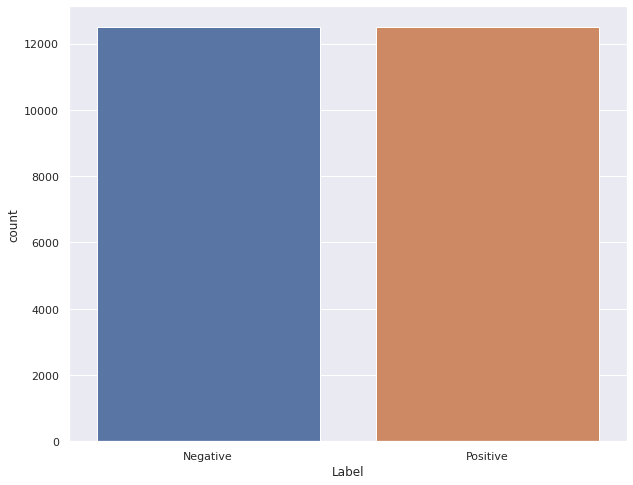

In [8]:
plt.subplots(1,1,figsize=(10,8))
sns.countplot(x="Label", data=train_df);

It looks like our dataset is perfectly balanced between positive and negative reviews. Let's look at an example of each to better understand their polarity.

In [9]:
print('Negative Example: \n')
print(train_df.loc[0, 'Text'],'\n')
print('Positive Example: \n')
print(train_df.loc[3, 'Text'])

Negative Example: 

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it. 

Positive Example: 

This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) 

In the negative example we see words like "terrible", "worst", and "pathetic"; while in the positive example we see "wonderful" and "praise". I would expect these sorts of words to be the major indicators in classification.

One question related to this dataset I would like to answer is how long is the average sequence length (in words), and what is this distribution within our classes?

In [10]:
train_df['Length'] = train_df['Text'].str.split().apply(len)

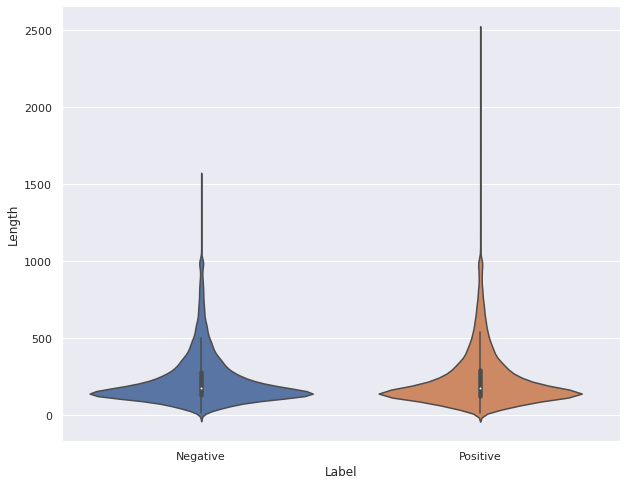

In [11]:
plt.subplots(1,1,figsize=(10,8))
sns.violinplot(x="Label", y="Length", data=train_df);

In [12]:
print('Average sequence length: {}'.format(train_df['Length'].mean()))

Average sequence length: 233.7872


In the violin plot above we can see that both classes have a very similar distribution of sequence lengths. The "positive" class seems to have a few longer ones than the "negative", but the bulk of the reviews are fewer than 500 words in length. We can see this further validated as the average sequence length (independent of class) is around 230 words.

The final thing we will do with this dataset is examine its structure as a corpus. To do this we will tokenize our data, and we will also remove so-called "stop-words". These are words that are very common (e.g. "the", "a", etc.). Doing this will help us focus on more important words with regards to text classification.

In [13]:
#This will download the nltk stopwords if you uncomment below
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords') #Only need this if not yet downloaded
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We are using a package (nltk) to provide the stopwords, and we can see all of these printed above. We then define a function below to clean our text. We will apply this to our dataframe and then tokenize.

In [20]:
import re
import string

def clean_text(text):
    #Convert to lower case
    text = text.lower()
    
    #Remove punctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    #Remove stop words
    text = [word for word in text.split() if word not in stopwords.words('english')]
    
    return ' '.join(text)

In [21]:
test_text = train_df.loc[0,'Text']
print(test_text,'\n')
print(clean_text(test_text))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it. 

absolutely terrible movie dont lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movies ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels making cases revolutions maria conchit

We can see the output from testing our text cleaning function above. It seems to be working well, and clearly we are narrowing the focus by removing very common words. For our purposes this is good as I am interested in the distribution of more important words. However, for certain text based tasks removing all the stop words can eradicate certain nuances in meaning. It is definitely important to be thoughtful when doing this.

In [22]:
#NOTE: This takes a long time to run
train_df['Text'] = train_df['Text'].apply(lambda x: clean_text(x))

In [30]:
#Saving processed data as csv just in case we want to use it later
# train_df.loc[:,'Label':'Text'].to_csv('imdb_csv/imdb_reviews.csv')

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer

T = Tokenizer()
T.fit_on_texts(train_df['Text'])

In [39]:
v_size = len(T.word_index)+1
print('Vocab size: ', v_size)

Vocab size:  137774
Most frequent word:  movie


We have almost 140,000 unique words in our corpus, and (not very surprisingly) the word "movie" is the most common. Below we can see the top 10 most common words and the total number of appearances.

In [50]:
print('Top 10 most frequent words: \n')
for i in range(1,11):
    word = T.index_word[i]
    print('{}. {} ({})'.format(i, word, T.word_counts[word]))

Top 10 most frequent words: 

1. movie (41799)
2. film (37460)
3. one (25150)
4. like (19561)
5. good (14508)
6. even (12325)
7. would (12122)
8. time (11782)
9. really (11639)
10. story (11431)


Words like "good" and "really" seem importat to classification, but words like "movie" or "story" are more independent with respect to polarity. Thus handling in the un-balanced distributions of words is still important.

In [42]:
counts = sorted([count for key, count in T.word_counts.items()], reverse=True)

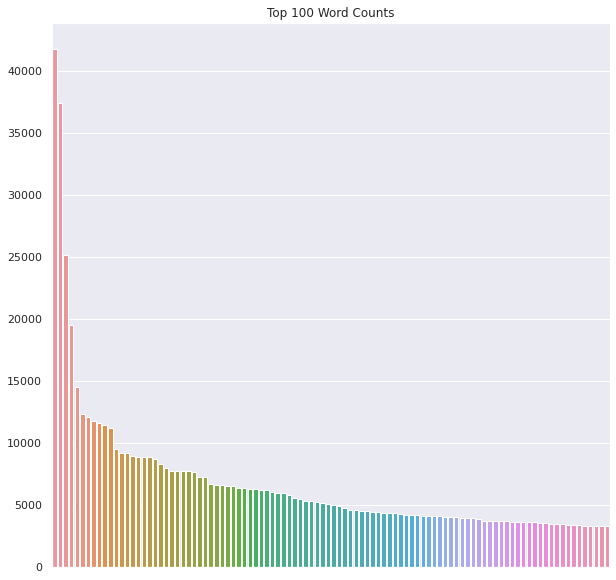

In [49]:
n = 100
x = np.arange(1, n+1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot = sns.barplot(x=x, y=counts[:n], ax=ax)
plot.set(xticklabels=[])
plot.set(xlabel=None)
plot.tick_params(bottom=False)
plot.set(title='Top 100 Word Counts');

Lastly, we see the distribution of word counts among the top 100 words. It appears that there is less of a power law type distribution.